In [1]:
from time import time
try:
    import flax.linen as nn
except:
    !pip install flax
    import flax.linen as nn

import jax
from jax.flatten_util import ravel_pytree
import jax.tree_util as jtu
import jax.numpy as jnp
import pandas as pd
# jnp.set_printoptions(linewidth=2000)

try:
    import optax
except:
    !pip install optax
    import optax

from tqdm import trange
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
jax.config.update("jax_enable_x64", False)
import sys
sys.path.append('../')
from bijax.laplace import Laplace_test

# %reload_ext watermark

In [2]:
class MLP(nn.Module):
    features: list

    @nn.compact  
    def __call__(self, x):
        for i, feature in enumerate(self.features):
            x = nn.Dense(feature, name=f"{i}_Dense")(x)
            if i != len(self.features)-1:
                x = nn.relu(x)
        return x   

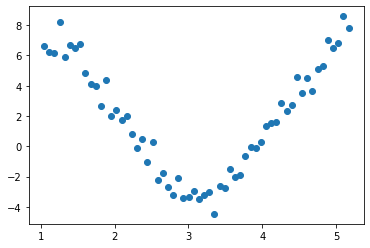

In [3]:
# Data
k1, k2 = jax.random.split(jax.random.PRNGKey(20), 2)
X = jnp.array([i*jnp.pi/180 for i in range(60,300,4)]).reshape(-1,1) 
y = 5*jnp.sin(1.5*X) + 2 + 0.7*jax.random.normal(k1,X.shape)
X.shape, y.shape
plt.scatter(X, y)

In [15]:
features = [2, 5, 1]
model = MLP(features)

In [16]:
prior = {"params": tfd.Normal(0,1)}
bijector = {"params": tfb.Identity()}
laplace = Laplace_test(prior, bijector, model=model, is_flax_model=True, subset_of_weights="all", hessian_structure="kfac")

Final Loss: 1304.9672
means--> 3 <class 'list'>


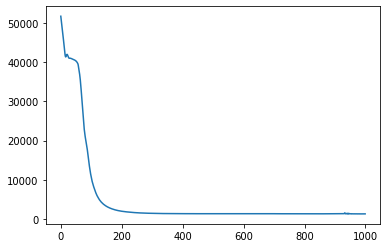

In [17]:
# key={'params': jax.random.PRNGKey(0)}
key = jax.random.PRNGKey(0)
map_params = laplace.fit(X, y, key)
laplace_dist = laplace.laplace_distribution

In [18]:
n_samples=1000
X_range = jnp.linspace(0,6,200).reshape(-1,1)
y_pred = laplace_dist.predict(X_range, seed=jax.random.PRNGKey(10), shape=(n_samples,))

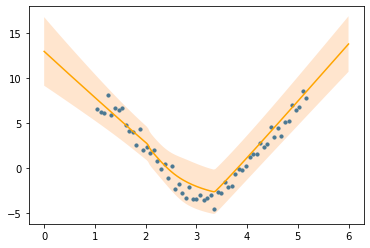

In [19]:
y_pred_mean, y_pred_std = y_pred.mean(axis=0), y_pred.std(axis=0)
plt.scatter(X, y, 10)
# plt.scatter(X, y_map)
plt.plot(X_range, y_pred_mean, c="orange")
plt.fill_between(X_range.squeeze(), (y_pred_mean-1.96*y_pred_std).squeeze(), (y_pred_mean+1.96*y_pred_std).squeeze(), alpha=0.2)